# Fraud Detection (Neon4j)

In [3]:
# Connect to your Neo4j Aura instance
NEO4J_URI = "your_neo4j_uri"
NEO4J_USER = "neo4j"
NEO4J_PASSWORD = "your_neo4j_password"

In [4]:
graph = Graph(NEO4J_URI, auth=(NEO4J_USER, NEO4J_PASSWORD))
print("Connected to Neo4j Aura!")

Connected to Neo4j Aura!


In [5]:
# Sample dataset for Fraud Detection
# Example: transactions between users
data = {
    'from': ['Alice', 'Alice', 'Bob', 'Charlie', 'David', 'Eve', 'Frank', 'Alice'],
    'to':   ['Bob', 'Charlie', 'David', 'Eve', 'Frank', 'Alice', 'Charlie', 'Frank'],
    'amount': [200, 5000, 700, 10000, 300, 4500, 6000, 12000]
}
df = pd.DataFrame(data)

In [6]:
# Load data into Neo4j
graph.run("MATCH (n) DETACH DELETE n")  # Clear existing nodes (optional)
for idx, row in df.iterrows():
    graph.run("""
    MERGE (a:Person {name:$from_name})
    MERGE (b:Person {name:$to_name})
    MERGE (a)-[:TRANSFER {amount:$amt}]->(b)
    """, from_name=row['from'], to_name=row['to'], amt=row['amount'])

print(" Sample transactions loaded to Neo4j!")

 Sample transactions loaded to Neo4j!


In [7]:
# Query for suspicious transactions (e.g., amount > 5000)
query = """
MATCH (a)-[t:TRANSFER]->(b)
WHERE t.amount > 5000
RETURN a.name AS Sender, b.name AS Receiver, t.amount AS Amount
"""
suspicious = graph.run(query).to_data_frame()
print("\nSuspicious Transactions:")
print(suspicious)




Suspicious Transactions:
    Sender Receiver  Amount
0    Alice    Frank   12000
1  Charlie      Eve   10000
2    Frank  Charlie    6000


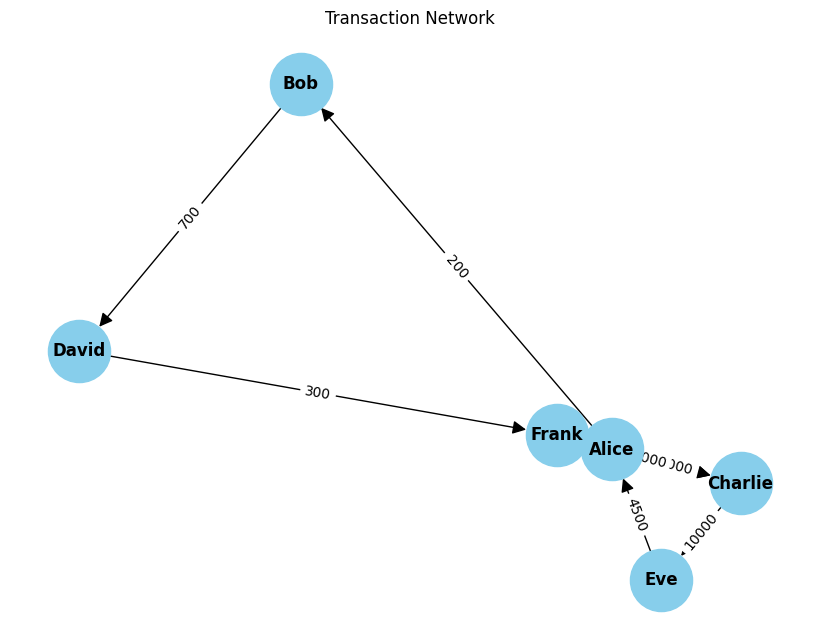

In [8]:
# Visualize the transaction graph
edges = df[['from', 'to', 'amount']].values
G = nx.DiGraph()
for e in edges:
    G.add_edge(e[0], e[1], weight=e[2])

plt.figure(figsize=(8,6))
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_size=2000, node_color='skyblue', font_size=12, font_weight='bold', arrowsize=20)
edge_labels = nx.get_edge_attributes(G,'weight')
nx.draw_networkx_edge_labels(G,pos,edge_labels=edge_labels)
plt.title("Transaction Network")
plt.show()


In [1]:
# Install required packages
!pip install py2neo pandas networkx matplotlib

In [2]:
# Import libraries
from py2neo import Graph
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# Fraud Detection (Neon4j+Cypher)

In [13]:
# Install Required Packages
!pip install py2neo pandas networkx matplotlib faker

In [14]:
# Import Libraries
from py2neo import Graph, Node, Relationship
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from faker import Faker
import random

fake = Faker()

In [15]:
# Connect to Neo4j Aura
NEO4J_URI = "your_neo4j_uri"
NEO4J_USER = "neo4j"
NEO4J_PASSWORD = "your_neo4j_password"

In [16]:

graph = Graph(NEO4J_URI, auth=(NEO4J_USER, NEO4J_PASSWORD))
print("Connected to Neo4j Aura!")

Connected to Neo4j Aura!


In [17]:
# Generate a Synthetic Transaction Dataset
num_users = 10
num_transactions = 50
users = [f"U{i}" for i in range(1, num_users+1)]
data = []

for i in range(1, num_transactions+1):
    user = random.choice(users)
    amount = random.randint(10, 10000)
    location = fake.country_code()
    # Randomly mark ~20% transactions as fraud
    is_fraud = 1 if random.random() < 0.2 else 0
    data.append([i, user, amount, location, is_fraud])

df = pd.DataFrame(data, columns=["transaction_id", "user_id", "amount", "location", "is_fraud"])

In [18]:
# Push Data into Neo4j
for _, row in df.iterrows():
    user_node = Node("User", user_id=row["user_id"])
    tx_node = Node("Transaction", transaction_id=row["transaction_id"], amount=row["amount"], location=row["location"], is_fraud=row["is_fraud"])

    graph.merge(user_node, "User", "user_id")
    graph.create(tx_node)

    rel = Relationship(user_node, "MADE", tx_node)
    graph.create(rel)

print("Synthetic fraud detection dataset uploaded to Neo4j!")

Synthetic fraud detection dataset uploaded to Neo4j!


In [19]:
# Neo4j Analytics - Suspicious Users (High Fraud Transactions)
query = """
MATCH (u:User)-[:MADE]->(t:Transaction)
WITH u, sum(t.is_fraud) AS fraud_count
WHERE fraud_count > 0
RETURN u.user_id AS user, fraud_count
ORDER BY fraud_count DESC
"""
suspicious_users = graph.run(query).to_data_frame()
print("Suspicious Users (with number of frauds):")
print(suspicious_users)

Suspicious Users (with number of frauds):
  user  fraud_count
0   U6            8
1   U5            5
2   U9            4
3   U2            4
4   U3            4
5   U1            4
6   U7            4
7   U8            2
8   U4            2
9  U10            1


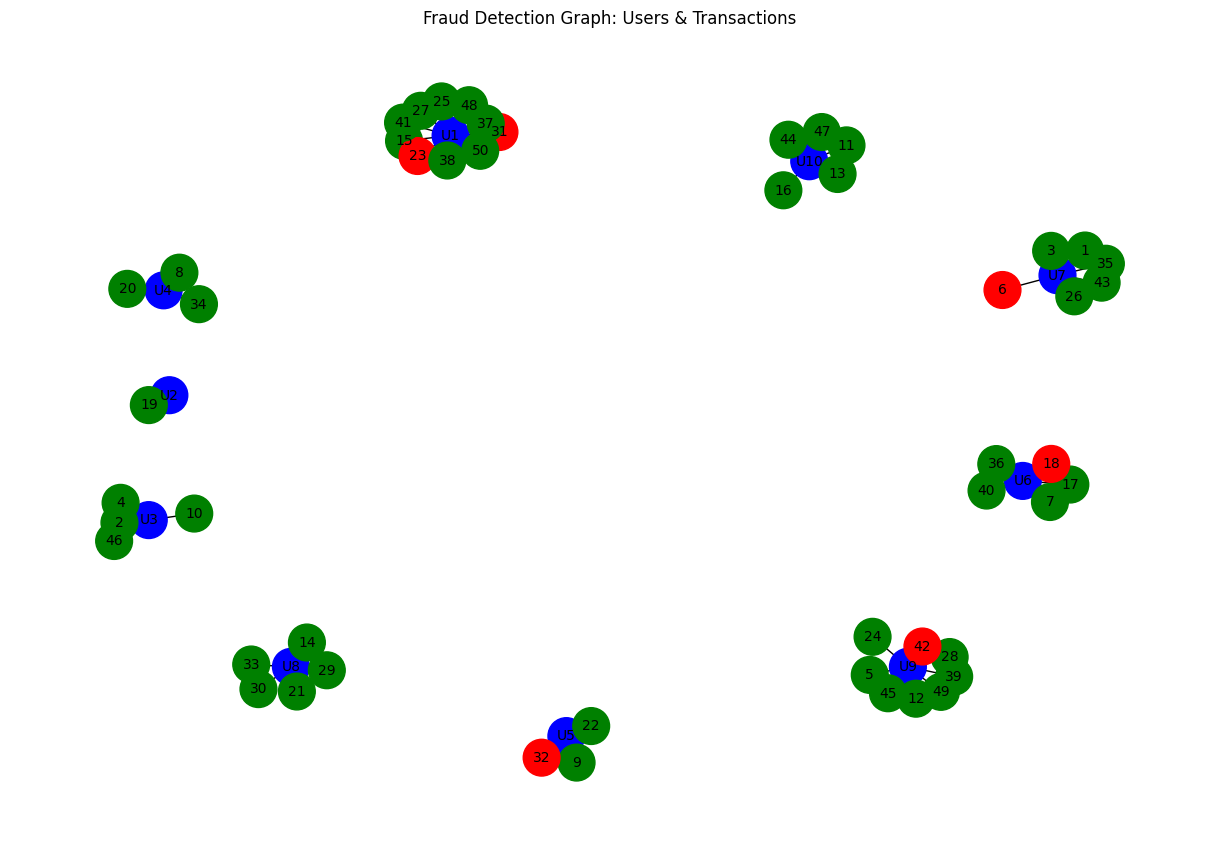

In [20]:
# Build Network Graph for Visualization
G = nx.Graph()
for _, row in df.iterrows():
    G.add_node(row["user_id"], type="user")
    G.add_node(row["transaction_id"], type="transaction", fraud=row["is_fraud"])
    G.add_edge(row["user_id"], row["transaction_id"])

# Highlight suspicious transactions in red
node_colors = [
    "red" if G.nodes[n].get("fraud") == 1 else "green" if G.nodes[n].get("type") == "transaction" else "blue"
    for n in G.nodes
]

pos = nx.spring_layout(G, seed=42)
plt.figure(figsize=(12,8))
nx.draw(G, pos, with_labels=True, node_color=node_colors, node_size=700, font_size=10)
plt.title("Fraud Detection Graph: Users & Transactions")
plt.show()

In [21]:
# Graph Metrics - Centrality to detect influential fraud nodes
centrality = nx.degree_centrality(G)
top_nodes = sorted(centrality.items(), key=lambda x: x[1], reverse=True)[:5]
print("Top 5 most connected nodes (potential key fraudsters or hubs):")
for node, score in top_nodes:
    print(node, score)


Top 5 most connected nodes (potential key fraudsters or hubs):
U1 0.1694915254237288
U9 0.13559322033898305
U7 0.1016949152542373
U6 0.0847457627118644
U10 0.0847457627118644
